In [19]:
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import lightning.pytorch as pl
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
import tensorboard

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the root directory
root_directory = os.path.abspath(os.path.join(current_dir, '..'))

# Add the root directory to the system path
sys.path.append(root_directory)

# Verify the path addition
from helper_utils import *
from U_Net import *
from U_Net_helper_functions import *
from TIF_dataset import *
from pytorch_lightning.loggers import TensorBoardLogger

Set this to the path to the folder in which you have extracted the datasets. Training without the GPU may take a very long time. 

In [41]:
path_to_data_folder = convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Dodatkowe_projekty\Zobaczmy_cell_tracking_unet\CTUN_moj\data')

EXECUTE THE CELL BELOW TO PERFORM DATA AUGMENTATION

In [ ]:
dataset_name1 = '/' + 'Fluo-N2DL-HeLa'
dataset_name2 = '/' + 'PhC-C2DH-U373'
dataset_name3 = '/' + 'DIC-C2DH-HeLa'
k = 1

perform_data_augmentation_on_dataset(path_to_data_folder, dataset_name1, k)
perform_data_augmentation_on_dataset(path_to_data_folder, dataset_name2, k)
perform_data_augmentation_on_dataset(path_to_data_folder, dataset_name3, k)

For training the multimodal model

In [ ]:
image_folder_paths = convert_backslashes_to_forward_slashes(path_to_data_folder + r"\PhC-C2DH-U373\augmented_images")
label_folder_paths = convert_backslashes_to_forward_slashes(path_to_data_folder + r"\PhC-C2DH-U373\augmented_image_labels")

image_paths_phc =  list_files_in_folder(image_folder_paths)
label_paths_phc =  list_files_in_folder(label_folder_paths)

image_folder_paths = convert_backslashes_to_forward_slashes(path_to_data_folder + r"\DIC-C2DH-HeLa\augmented_images")
label_folder_paths = convert_backslashes_to_forward_slashes(path_to_data_folder + r"\DIC-C2DH-HeLa\augmented_image_labels")

image_paths_dic =  list_files_in_folder(image_folder_paths)
label_paths_dic =  list_files_in_folder(label_folder_paths)

image_folder_paths = convert_backslashes_to_forward_slashes(path_to_data_folder + r"\Fluo-N2DL-HeLa\augmented_images")
label_folder_paths = convert_backslashes_to_forward_slashes(path_to_data_folder + r"\Fluo-N2DL-HeLa\augmented_image_labels")

image_paths_flo =  list_files_in_folder(image_folder_paths)
label_paths_flo =  list_files_in_folder(label_folder_paths)

In [22]:
image_paths =  image_paths_phc + image_paths_dic + image_paths_flo
label_paths =  label_paths_phc + label_paths_dic + label_paths_flo

In [ ]:
def permute_together(list1, list2):
    assert len(list1) == len(list2), "Lists have to have the same length"
    indices = list(range(len(list1)))
    random.shuffle(indices)
    list1_permuted = [list1[i] for i in indices]
    list2_permuted = [list2[i] for i in indices]
    return list1_permuted, list2_permuted

image_paths, label_paths = permute_together(image_paths, label_paths)

validation_image_paths = image_paths[int(0.9 * len(image_paths)):]
validation_label_paths = label_paths[int(0.9 * len(image_paths)):]

image_paths =  image_paths[:int(0.9 * len(image_paths))]
label_paths =  label_paths[:int(0.9 * len(label_paths))]

In [40]:
train_dataset = TIF_dataset(image_paths, label_paths)
val_dataset = TIF_dataset(validation_image_paths, validation_label_paths)

batch_size = 20

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
#train with pytorch lightning

# sizes = [1, 8, 16, 32, 128, 256]
sizes = [1, 2, 4]

# The variable sizes determines how many channels will there be in each layer of the U-net model. It also determines how deep the model will be.
# It is set to a very small list to enable a quick, few minutes training on a cpu. If you have a gpu, set it a greater values, eg
# [1, 8, 16, 32, 128, 256]

lightning_model = UNet(sizes, kernel_size=7, padding = 3)

trainer = pl.Trainer(max_epochs=1)

trainer.fit(model = lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type                | Params | Mode 
-------------------------------------------------------------
0 | bottom_path  | ModuleList          | 2.5 K  | train
1 | top_path     | ModuleList          | 1.4 K  | train
2 | UpConvs      | ModuleList          | 86     | train
3 | pool         | MaxPool2d           | 0      | train
4 | bottom_block | Convolutional_Block | 2.4 K  | train
5 | loss_fn      | CrossEntropyLoss    | 0      | eval 
-------------------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


   VALIDATION: Batch 0, loss 0.7060248255729675
   VALIDATION: Batch 1, loss 0.7057084441184998


c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

   TRRAINING: Batch 0, loss 0.7984296083450317
   TRRAINING: Batch 1, loss 0.7677363753318787
   TRRAINING: Batch 2, loss 0.7455605268478394
   TRRAINING: Batch 3, loss 0.7176433205604553
   TRRAINING: Batch 4, loss 0.6976131200790405
   TRRAINING: Batch 5, loss 0.6879265904426575
   TRRAINING: Batch 6, loss 0.6756106615066528
   TRRAINING: Batch 7, loss 0.6666356921195984
   TRRAINING: Batch 8, loss 0.6585306525230408
   TRRAINING: Batch 9, loss 0.681490957736969
   TRRAINING: Batch 10, loss 0.6469048857688904
   TRRAINING: Batch 11, loss 0.6591584086418152
   TRRAINING: Batch 12, loss 0.6636384725570679
   TRRAINING: Batch 13, loss 0.6466795802116394
   TRRAINING: Batch 14, loss 0.6165099143981934
   TRRAINING: Batch 15, loss 0.6240925192832947
   TRRAINING: Batch 16, loss 0.5971237421035767
   TRRAINING: Batch 17, loss 0.5879824757575989
   TRRAINING: Batch 18, loss 0.5833625793457031
   TRRAINING: Batch 19, loss 0.6142585277557373
   TRRAINING: Batch 20, loss 0.6468391418457031
   

Validation: |          | 0/? [00:00<?, ?it/s]

   VALIDATION: Batch 0, loss 0.5395400524139404
   VALIDATION: Batch 1, loss 0.545732319355011
   VALIDATION: Batch 2, loss 0.5639496445655823
   VALIDATION: Batch 3, loss 0.5586832165718079
   VALIDATION: Batch 4, loss 0.5703085660934448
   VALIDATION: Batch 5, loss 0.5695209503173828
   VALIDATION: Batch 6, loss 0.5902930498123169
   VALIDATION: Batch 7, loss 0.5831512808799744
   VALIDATION: Batch 8, loss 0.5923088192939758
   VALIDATION: Batch 9, loss 0.5826407074928284
   VALIDATION: Batch 10, loss 0.5942586064338684
   VALIDATION: Batch 11, loss 0.6030721068382263
   VALIDATION: Batch 12, loss 0.5911037921905518
   VALIDATION: Batch 13, loss 0.5965895056724548
   VALIDATION: Batch 14, loss 0.5877370834350586


`Trainer.fit` stopped: `max_epochs=1` reached.


   VALIDATION: Batch 15, loss 0.6043779253959656


In [26]:
val_loss = lightning_model.run_model_on_validation_dataloder(val_dataloader)
print(val_loss)

Avarage validation loss per batch:  0.5795792266726494
0.5795792266726494


Save the model

In [27]:
# torch.save(lightning_model.state_dict(), convert_backslashes_to_forward_slashes(r'C:\Users\Komputer\Documents\Hackaton_heidelberg\CellTrackingU-Net\saved_models\BIG_model_DIC'))
torch.save(lightning_model, convert_backslashes_to_forward_slashes(r'C:\Users\Dell\Documents\Dodatkowe_projekty\Zobaczmy_cell_tracking_unet\CTUN_moj\saved_models\BIG_model_MULTIMODAL'))

SANITY CHECK: lets look at some examples. They are not ideal because they come from a very small model trained without GPU acceleration. 

Model output


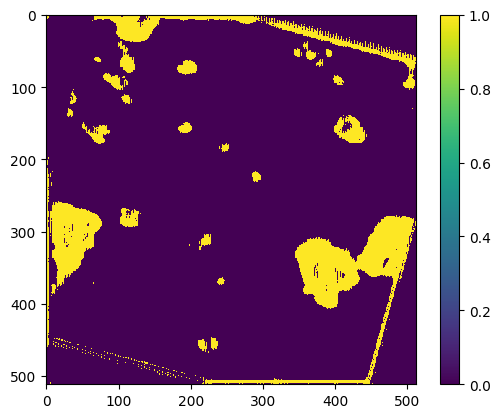

Label


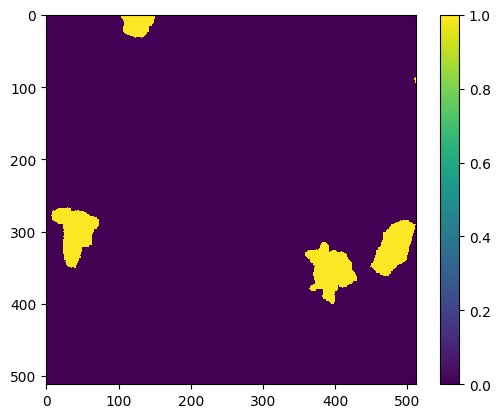

original image


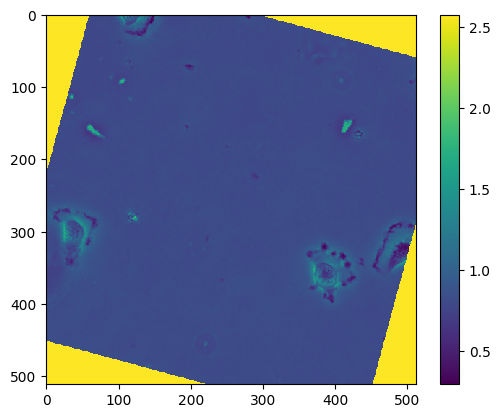

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data, label = val_dataset[4]
data = data.to(device)
label = label.to(device)


lightning_model.eval()
with torch.no_grad():
    output = lightning_model(data.cpu().unsqueeze(dim = 0))
    model_return_numpy = channel_comparison(output.cpu())
    print('Model output')
    plot_heatmap(model_return_numpy)
    print('Label')
    plot_heatmap(label.cpu().squeeze().numpy())
    print('original image')
    plot_heatmap(data.cpu().squeeze().numpy())